## Categorical values

In [1]:
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from numpy import power
from math import inf

from spotPython.spot import spot
from spotPython.utils.convert import class_for_name
from spotPython.hyperparameters.values import (modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds, get_default_values, get_var_name, get_var_type, get_bound_values,
    get_dict_with_levels_and_types)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotRiver.fun.hyperriver import HyperRiver
from spotRiver.utils.selectors import select_leaf_prediction, select_leaf_model
from spotRiver import data
from spotRiver.data.bike_sharing import get_bike_sharing_data
from spotRiver.data.river_hyper_dict import HyperDict
from spotRiver.utils.assignments import assign_values, iterate_dict_values, convert_keys

from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder , MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_absolute_error

import river.stream as river_stream
from river.tree.splitter import EBSTSplitter, QOSplitter, TEBSTSplitter, GaussianSplitter, HistogramSplitter
from river.linear_model import LinearRegression, PARegressor, Perceptron
from river.tree import HoeffdingAdaptiveTreeRegressor
from river.preprocessing import StandardScaler
from river.compose import Pipeline
from river import compose
from river import datasets, time_series, utils, compose, linear_model, optim, preprocessing, evaluate, metrics, tree 
from river.datasets import synth
from river import feature_extraction
from river import stats, compose, preprocessing, tree
from river import metrics
warnings.filterwarnings("ignore")

## Bike Sharing

In [2]:
df, train, test = get_bike_sharing_data()
target_column="count"
n_samples = df.shape[0]
X = copy.deepcopy(train)
y = X.pop("count")
data = river_stream.iter_pandas(X, y)
dataset = list(data)
#
categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]
categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]

m = test.shape[0]
a = int(m/2)-100
b = int(m/2)

## Load default `hyper_dict` for all algorithms, hyperparameters and levels

In [3]:
# river_hyper_dict = HyperDict().load()
# Load local hyper_dict:
with open("river_hyper_dict.json", "r") as f:
         river_hyper_dict = json.load(f)

In [4]:
fun_control = {}
core_model  = HoeffdingAdaptiveTreeRegressor
fun_control.update({"core_model": core_model})

## Select `algorithm` and `core_model_hyper_dict`

In [5]:
fun_control.update({"core_model_hyper_dict": river_hyper_dict[core_model.__name__]})

### Modify hyperparameter of type factor

In [6]:
fun_control = modify_hyper_parameter_levels(fun_control, "leaf_prediction", ["mean"])
fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

## Modify hyperparameter of type numeric

In [7]:
fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 11])
# fun_control

## Preprocessing model `prep_model`

In [8]:
# prep_model = StandardScaler()
prep_model = compose.Select("weekday", "month", "temp", "feel_temp", "humidity", "windspeed")
prep_model += (
    feature_extraction.TargetAgg(by=['hour'], how=stats.Mean())
)
prep_model |= preprocessing.StandardScaler()
prep_model
fun_control.update({"prep_model": prep_model})

## Get Type and Variable names

In [11]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
var_type


['int',
 'int',
 'float',
 'float',
 'factor',
 'factor',
 'float',
 'factor',
 'int',
 'factor',
 'int',
 'float',
 'factor',
 'float',
 'int',
 'factor',
 'factor',
 'factor']

## Get lower and upper bounds

In [12]:
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")


## Compile fun_control for spot

* To be updated: Check if fun_control is correct!

In [13]:
horizon = 7*24
oml_grace_period = 2
fun = HyperRiver(seed=123, log_level=50).fun_oml_horizon
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "target_column": target_column,
               "horizon": horizon,
               "oml_grace_period": oml_grace_period,
               "n_samples": n_samples,
               "weights": np.array([1, 1/1000, 1/1000])*10_000.0,
               "step": 100,
               "log_level": 50,
               "weight_coeff": 1.0,
               "metric": metrics.MAE(),
               "metric_sklearn": mean_absolute_error,
               "var_name": var_name,
               "var_type": var_type,
               "prep_model": prep_model
               })

In [14]:
fun_control

{'core_model': river.tree.hoeffding_adaptive_tree_regressor.HoeffdingAdaptiveTreeRegressor,
 'core_model_hyper_dict': {'grace_period': {'type': 'int',
   'default': 200,
   'transform': 'None',
   'lower': 10,
   'upper': 1000},
  'max_depth': {'type': 'int',
   'default': 20,
   'transform': 'transform_power_2',
   'lower': 2,
   'upper': 20},
  'delta': {'type': 'float',
   'default': 1e-07,
   'transform': 'None',
   'lower': 1e-08,
   'upper': 1e-06},
  'tau': {'type': 'float',
   'default': 0.05,
   'transform': 'None',
   'lower': 0.01,
   'upper': 0.1},
  'leaf_prediction': {'levels': ['mean'],
   'type': 'factor',
   'default': 'mean',
   'transform': 'None',
   'core_model_parameter_type': 'str',
   'lower': 0,
   'upper': 0},
  'leaf_model': {'levels': ['LinearRegression'],
   'type': 'factor',
   'default': 'LinearRegression',
   'transform': 'None',
   'class_name': 'river.linear_model',
   'core_model_parameter_type': 'instance',
   'lower': 0,
   'upper': 0},
  'model_sel

# Test if fun_control is correct

## fun_hyperriver: fun_oml_horizon

* Generate  (simulated) X hyperparameter config from spot():

In [16]:
X = get_default_values(fun_control)
# get values from dict as np.array. If string, return zero
X = np.array([float(X[key]) if isinstance(X[key], numbers.Number) else 0 for key in X.keys()])
X

array([2.0e+02, 2.0e+01, 1.0e-07, 5.0e-02, 0.0e+00, 0.0e+00, 9.5e-01,
       0.0e+00, 5.0e+00, 0.0e+00, 3.0e+02, 5.0e-02, 0.0e+00, 5.0e+02,
       1.0e+06, 0.0e+00, 0.0e+00, 0.0e+00])

In [17]:
X = np.array([X])
X.shape[1]
var_dict = assign_values(X, fun_control["var_name"])
var_dict

{'grace_period': array([200.]),
 'max_depth': array([20.]),
 'delta': array([1.e-07]),
 'tau': array([0.05]),
 'leaf_prediction': array([0.]),
 'leaf_model': array([0.]),
 'model_selector_decay': array([0.95]),
 'splitter': array([0.]),
 'min_samples_split': array([5.]),
 'bootstrap_sampling': array([0.]),
 'drift_window_threshold': array([300.]),
 'switch_significance': array([0.05]),
 'binary_split': array([0.]),
 'max_size': array([500.]),
 'memory_estimate_period': array([1000000.]),
 'stop_mem_management': array([0.]),
 'remove_poor_attrs': array([0.]),
 'merit_preprune': array([0.])}

In [18]:
fun_control["var_type"]

['int',
 'int',
 'float',
 'float',
 'factor',
 'factor',
 'float',
 'factor',
 'int',
 'factor',
 'int',
 'float',
 'factor',
 'float',
 'int',
 'factor',
 'factor',
 'factor']

In [19]:
for values in iterate_dict_values(var_dict):
            values = convert_keys(values, fun_control["var_type"])
            print(values)
            values = get_dict_with_levels_and_types(fun_control=fun_control, v=values)
            values = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values)
            print(values)
            model = compose.Pipeline(fun_control["prep_model"], fun_control["core_model"](**values))

{'grace_period': 200, 'max_depth': 20, 'delta': 1e-07, 'tau': 0.05, 'leaf_prediction': 0, 'leaf_model': 0, 'model_selector_decay': 0.95, 'splitter': 0, 'min_samples_split': 5, 'bootstrap_sampling': 0, 'drift_window_threshold': 300, 'switch_significance': 0.05, 'binary_split': 0, 'max_size': 500.0, 'memory_estimate_period': 1000000, 'stop_mem_management': 0, 'remove_poor_attrs': 0, 'merit_preprune': 0}
{'grace_period': 200, 'max_depth': 1048576, 'delta': 1e-07, 'tau': 0.05, 'leaf_prediction': 'mean', 'leaf_model': <class 'river.linear_model.lin_reg.LinearRegression'>, 'model_selector_decay': 0.95, 'splitter': EBSTSplitter (), 'min_samples_split': 5, 'bootstrap_sampling': 0, 'drift_window_threshold': 300, 'switch_significance': 0.05, 'binary_split': 0, 'max_size': 500.0, 'memory_estimate_period': 1000000, 'stop_mem_management': 0, 'remove_poor_attrs': 0, 'merit_preprune': 0}


In [20]:
values

{'grace_period': 200,
 'max_depth': 1048576,
 'delta': 1e-07,
 'tau': 0.05,
 'leaf_prediction': 'mean',
 'leaf_model': river.linear_model.lin_reg.LinearRegression,
 'model_selector_decay': 0.95,
 'splitter': EBSTSplitter (),
 'min_samples_split': 5,
 'bootstrap_sampling': 0,
 'drift_window_threshold': 300,
 'switch_significance': 0.05,
 'binary_split': 0,
 'max_size': 500.0,
 'memory_estimate_period': 1000000,
 'stop_mem_management': 0,
 'remove_poor_attrs': 0,
 'merit_preprune': 0}

In [22]:
from spotRiver.evaluation.eval_bml import eval_oml_horizon
eval_oml_horizon(
                    model=model,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

(      Metric  Memory (MB)  CompTime (s)
 0        NaN     0.060090      0.002192
 1   0.181150     0.629938      0.057549
 2   0.171039     0.745264      0.293957
 3   0.126652     0.504434      0.245068
 4   0.111308     0.711018      0.110999
 5   0.113703     0.703635      0.264412
 6   0.123865     0.563879      0.269861
 7   0.090645     0.705828      0.094838
 8   0.099753     0.660360      0.333064
 9   0.104110     0.722749      0.099826
 10  0.106796     0.741075      0.365424
 11  0.099175     0.604262      0.335597
 12  0.116016     0.680594      0.229675
 13  0.109834     0.669992      0.347839
 14  0.109915     0.746533      0.318938
 15  0.097033     0.856433      0.301372
 16  0.087399     0.740820      0.076370
 17  0.087669     0.754246      0.232332
 18  0.099367     0.748721      0.090063
 19  0.104198     0.732435      0.098398
 20  0.098435     0.758745      0.413247
 21  0.096890     0.718737      0.348988
 22  0.094855     0.742102      0.096450
 23  0.093655   

# Run SPOT

In [23]:
spot_htr = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 1,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   var_name=var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 10,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 20,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_htr.run()

Error in fun_oml_horizon(). Call to eval_oml_horizon failed. err=RecursionError('maximum recursion depth exceeded while calling a Python object'), type(err)=<class 'RecursionError'>
Error in fun_oml_horizon(). Call to eval_oml_horizon failed. err=RecursionError('maximum recursion depth exceeded while calling a Python object'), type(err)=<class 'RecursionError'>
Error in fun_oml_horizon(). Call to eval_oml_horizon failed. err=RecursionError('maximum recursion depth exceeded while calling a Python object'), type(err)=<class 'RecursionError'>
Error in fun_oml_horizon(). Call to eval_oml_horizon failed. err=RecursionError('maximum recursion depth exceeded while calling a Python object'), type(err)=<class 'RecursionError'>
Error in fun_oml_horizon(). Call to eval_oml_horizon failed. err=RecursionError('maximum recursion depth exceeded while calling a Python object'), type(err)=<class 'RecursionError'>
spotPython tuning: [##########] 100.00% Done...


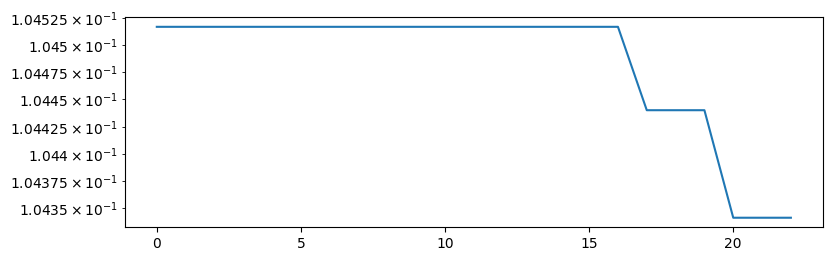

In [24]:
spot_htr.plot_progress(log_y=True)

In [25]:
spot_htr.print_results()

min y: 0.10434139681726344
grace_period: 774.0
max_depth: 15.0
delta: 0.0
tau: 0.0
leaf_prediction: 0.0
leaf_model: 0.0
model_selector_decay: 1.0
splitter: 1.0
min_samples_split: 4.0
bootstrap_sampling: 1.0
drift_window_threshold: 146.0
switch_significance: 0.0
binary_split: 0.0
max_size: 228.0
memory_estimate_period: 265441.0
stop_mem_management: 0.0
remove_poor_attrs: 0.0
merit_preprune: 1.0


In [26]:
spot_htr.print_importance()

Importance relative to the most important parameter:
grace_period:  1.646041847258879e-05
max_depth:  0.0028820597369303767
delta:  0.00124145275045118
tau:  58.455352209032554
model_selector_decay:  0.021569620941124294
splitter:  86.59675165292198
min_samples_split:  100.0
bootstrap_sampling:  0.3707631320190459
drift_window_threshold:  0.0003012102897501327
switch_significance:  0.01089351420455546
binary_split:  0.043193624338467074
max_size:  27.486290157123513
memory_estimate_period:  5.9095711486335745e-05
stop_mem_management:  17.998104911197245
remove_poor_attrs:  0.009127447992128262
merit_preprune:  5.5608213164883375e-05
